In [1]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 98% 303M/309M [00:01<00:00, 157MB/s]
100% 309M/309M [00:02<00:00, 160MB/s]


In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2024-01-19 04:04:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-19 04:04:47 (82.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
# prompt: unzip data

unzip_data('/content/human-emotions-datasethes.zip')


In [10]:
train_dir = '/content/Emotions Dataset/Emotions Dataset/train'
val_dir = '/content/Emotions Dataset/Emotions Dataset/test'

In [33]:
walk_through_dir(train_dir)

There are 3 directories and 0 images in '/content/Emotions Dataset/Emotions Dataset/train'.
There are 0 directories and 2255 images in '/content/Emotions Dataset/Emotions Dataset/train/sad'.
There are 0 directories and 1525 images in '/content/Emotions Dataset/Emotions Dataset/train/angry'.
There are 0 directories and 3019 images in '/content/Emotions Dataset/Emotions Dataset/train/happy'.


In [11]:
walk_through_dir(val_dir)

There are 3 directories and 0 images in '/content/Emotions Dataset/Emotions Dataset/test'.
There are 0 directories and 757 images in '/content/Emotions Dataset/Emotions Dataset/test/sad'.
There are 0 directories and 515 images in '/content/Emotions Dataset/Emotions Dataset/test/angry'.
There are 0 directories and 1006 images in '/content/Emotions Dataset/Emotions Dataset/test/happy'.


In [21]:
IMG_SIZE = (224, 224)
BATCH=32

CLASS_NAMES = ['angry', 'happy', 'sad']
NUM_CLASSES = len(CLASS_NAMES)

In [29]:
# prompt: create val and train dataset using image_dataset_from_directory

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    label_mode='categorical'

)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
     label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)


Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


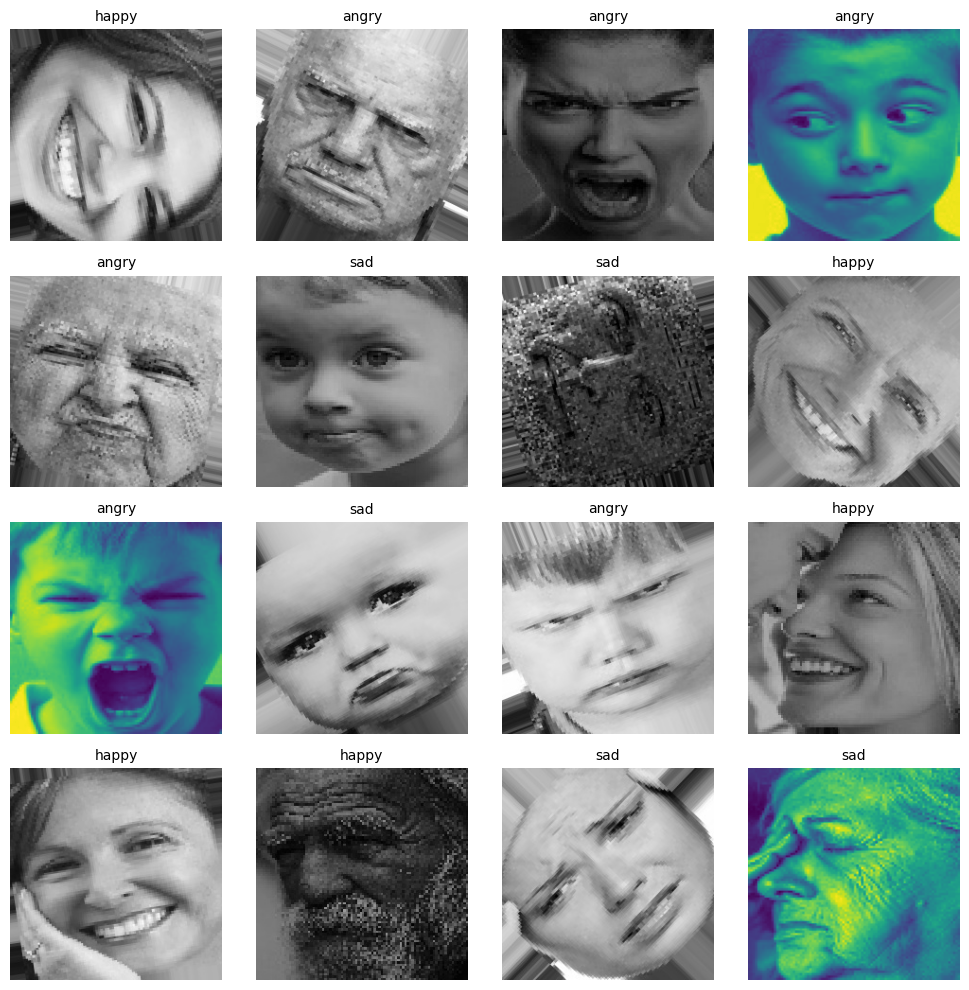

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def display_random_image_grid_with_labels(folder_path, num_rows, num_cols):
    """
    Display a grid of randomly selected images from subfolders with labels.

    Parameters:
    - folder_path (str): Path to the folder containing subfolders with images.
    - num_rows (int): Number of rows in the grid.
    - num_cols (int): Number of columns in the grid.
    """
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    # Get a list of subfolders (class labels)
    class_labels = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

    for i in range(num_rows):
        for j in range(num_cols):
            class_label = random.choice(class_labels)
            class_folder_path = os.path.join(folder_path, class_label)

            # Get a list of image files in the selected subfolder
            image_files = [f for f in os.listdir(class_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if image_files:
                # Shuffle the list of image files
                random.shuffle(image_files)

                # Select a random image to display
                img_path = os.path.join(class_folder_path, random.choice(image_files))
                img = mpimg.imread(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(class_label, fontsize=10)

    plt.tight_layout()
    plt.show()

# Example usage:
folder_path = train_dir
num_rows = 4
num_cols = 4

display_random_image_grid_with_labels(folder_path, num_rows, num_cols)


In [19]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

## Set up a base model

In [24]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture
inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalMaxPooling2D(name='global_max_pooling_layer')(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

In [25]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_max_pooling_layer (  (None, 1280)              0         
 GlobalMaxPooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                             

In [34]:
# prompt: compile and train model

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 3

history_model_1 = model_1.fit(train_dataset,
                              epochs=epochs,
                              validation_data=train_dataset,
                               validation_steps= int(0.1* len(val_dataset))
)




Epoch 1/3
213/213 [==============================] - 133s 584ms/step - loss: 1.1844 - accuracy: 0.5408 - val_loss: 1.2156 - val_accuracy: 0.5982
Epoch 2/3
213/213 [==============================] - 84s 394ms/step - loss: 0.9568 - accuracy: 0.6251 - val_loss: 1.0852 - val_accuracy: 0.5982
Epoch 3/3
213/213 [==============================] - 75s 350ms/step - loss: 0.8544 - accuracy: 0.6601 - val_loss: 0.9265 - val_accuracy: 0.6473


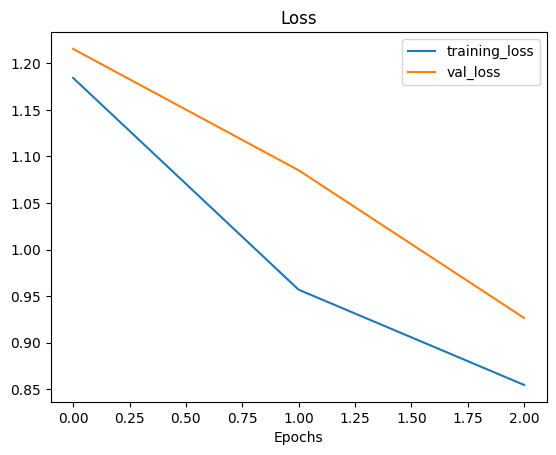

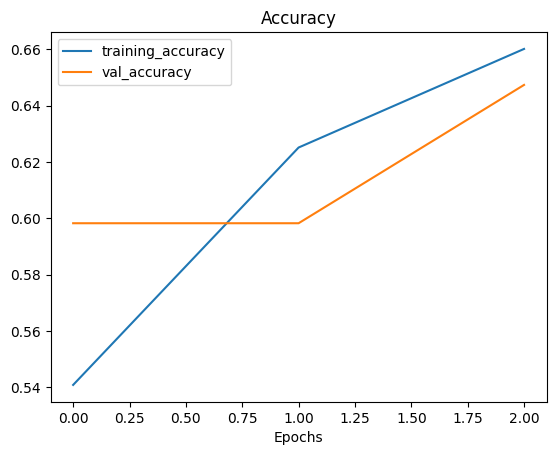

In [35]:
plot_loss_curves(history_model_1)


In [37]:
# prompt: make preditions with model

model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs[:10]

72/72 [==============================] - 4s 58ms/step


array([[0.9614706 , 0.0279995 , 0.01052993],
       [0.00925505, 0.85486436, 0.1358806 ],
       [0.04444466, 0.85848844, 0.09706692],
       [0.68075955, 0.00743628, 0.31180415],
       [0.6173602 , 0.15007111, 0.23256871],
       [0.55369157, 0.04591306, 0.4003953 ],
       [0.544355  , 0.0509612 , 0.40468386],
       [0.23657236, 0.03669942, 0.72672826],
       [0.44142336, 0.23234937, 0.32622728],
       [0.6988267 , 0.19470443, 0.10646892]], dtype=float32)

In [39]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:100]

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 0, 1, 2, 2, 2,
       0, 0, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 1,
       1, 2, 1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0,
       1, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 0])>

In [42]:
y_labels = []
for images, labels in val_dataset.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
from helper_functions import calculate_results
model_1_results = calculate_results(y_labels,model_1_preds )
model_1_results

{'accuracy': 64.57418788410887,
 'precision': 0.6440913814159673,
 'recall': 0.6457418788410887,
 'f1': 0.6386425832247418}

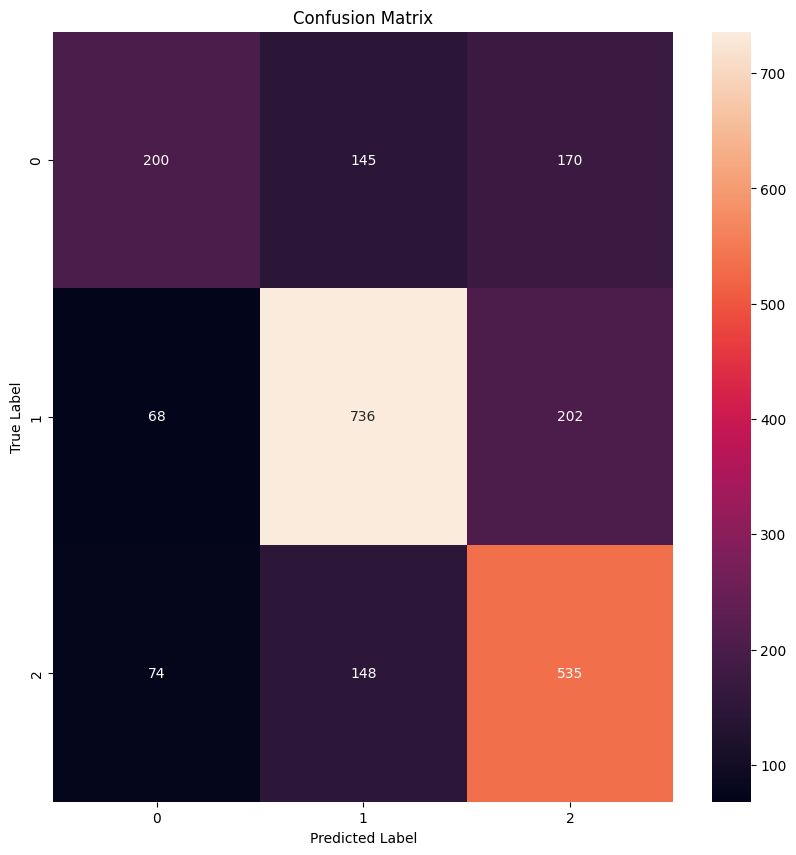

In [44]:
# prompt: make a fancy confusion matrix

import seaborn as sns

# Create a confusion matrix using the predicted labels and true labels
confusion_matrix = tf.math.confusion_matrix(y_labels, model_1_preds)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
